In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [7]:
# Load data
bowling = pd.read_csv("bowling_performance.csv")
batting = pd.read_csv("batting_performance.csv")

In [9]:
# --- Batting Metrics ---
batting['NSE'] = batting['Runs'] / (6 * batting['Balls Faced'])
batting['PWRS'] = (3 * batting['PP Runs'] + batting['Middle Runs'] + 2 * batting['Death Runs']) / 6
batting['LRS'] = (batting['Missed Catches'] + batting['Wrong Decisions']) / batting['Balls Faced']
batting['PWRS2'] = (batting['PWRS'] - batting['PWRS'].min()) / (batting['PWRS'].max() - batting['PWRS'].min())

In [11]:
# --- Bowling Metrics ---
bowling['PWWS'] = (3 * bowling['PP Wickets'] + bowling['Middle Wickets'] + 2 * bowling['Death Wickets']) / 6
bowling['Wicket_Weighted'] = 3 * bowling['PP Wickets'] + 2 * bowling['Middle Wickets'] + bowling['Death Wickets']
bowling['QWWS'] = bowling['Wicket_Weighted'] / bowling['Max Weighted Wickets in Match']
bowling['PWRC'] = 1 - ((3 * bowling['PP Runs'] + bowling['Middle Runs'] + 2 * bowling['Death Runs']) / (6 * bowling['Max Phase Runs']))
bowling['BCS'] = 1 - (bowling['Boundaries'] / bowling['Balls Bowled'])
bowling['MOR'] = bowling['Maiden Overs'] / bowling['Total Overs']

In [15]:
batting_cols = ['NSE', 'PWRS', 'LRS', 'PWRS2']
scaler = MinMaxScaler()
batting[batting_cols] = scaler.fit_transform(batting[batting_cols])
bowling_cols = ['PWWS', 'QWWS', 'PWRC', 'BCS', 'MOR']
scaler = MinMaxScaler()
bowling[bowling_cols] = scaler.fit_transform(bowling[bowling_cols])

In [70]:
# Aggregate per player
bat_agg = batting.groupby('Player')[batting_cols].mean().reset_index()
bowl_agg = bowling.groupby('Player')[bowling_cols].mean().reset_index()
print(bat_agg)
print(bowl_agg)

      Player       NSE      PWRS       LRS     PWRS2
0   Batter_1  0.279259  0.440870  0.295781  0.440870
1  Batter_10  0.271564  0.467923  0.307218  0.467923
2   Batter_2  0.258733  0.465604  0.275843  0.465604
3   Batter_3  0.300544  0.512754  0.274522  0.512754
4   Batter_4  0.352095  0.484251  0.306237  0.484251
5   Batter_5  0.304673  0.451014  0.241050  0.451014
6   Batter_6  0.285234  0.464155  0.298088  0.464155
7   Batter_7  0.322459  0.519710  0.280777  0.519710
8   Batter_8  0.310489  0.465314  0.276549  0.465314
9   Batter_9  0.330694  0.469275  0.307599  0.469275
      Player      PWWS      QWWS      PWRC       BCS       MOR
0   Bowler_1  0.575000  0.368287  0.613522  0.671608  0.346508
1  Bowler_10  0.526667  0.358782  0.604473  0.644271  0.344107
2   Bowler_2  0.450000  0.275481  0.621519  0.698969  0.275754
3   Bowler_3  0.527500  0.311146  0.636683  0.686012  0.362688
4   Bowler_4  0.486667  0.321116  0.586389  0.681524  0.384980
5   Bowler_5  0.561667  0.405974  0.620

In [19]:
# Calculate CPR scores
bat_agg['CPR_Batter'] = 0.25 * bat_agg['NSE'] + 0.25 * bat_agg['PWRS'] + 0.25 * bat_agg['LRS'] + 0.25 * bat_agg['PWRS2']
bowl_agg['CPR_Bowler'] = 0.2 * bowl_agg['PWWS'] + 0.2 * bowl_agg['QWWS'] + 0.2 * bowl_agg['PWRC'] + 0.2 * bowl_agg['BCS'] + 0.2 * bowl_agg['MOR']

In [21]:
print(bat_agg.head())
print(bowl_agg.head())


      Player       NSE      PWRS       LRS     PWRS2  CPR_Batter
0   Batter_1  0.279259  0.440870  0.295781  0.440870    0.364195
1  Batter_10  0.271564  0.467923  0.307218  0.467923    0.378657
2   Batter_2  0.258733  0.465604  0.275843  0.465604    0.366446
3   Batter_3  0.300544  0.512754  0.274522  0.512754    0.400143
4   Batter_4  0.352095  0.484251  0.306237  0.484251    0.406709
      Player      PWWS      QWWS      PWRC       BCS       MOR  CPR_Bowler
0   Bowler_1  0.575000  0.368287  0.613522  0.671608  0.346508    0.514985
1  Bowler_10  0.526667  0.358782  0.604473  0.644271  0.344107    0.495660
2   Bowler_2  0.450000  0.275481  0.621519  0.698969  0.275754    0.464344
3   Bowler_3  0.527500  0.311146  0.636683  0.686012  0.362688    0.504806
4   Bowler_4  0.486667  0.321116  0.586389  0.681524  0.384980    0.492135


In [23]:
# Feature columns
bat_features = ['NSE', 'PWRS', 'LRS', 'PWRS2']
bowl_features = ['PWWS', 'QWWS', 'PWRC', 'BCS', 'MOR']

In [25]:
# Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

In [27]:
# Store results
bat_results, bowl_results = [], []
model_outputs_bat, model_outputs_bowl = {}, {}

In [41]:
print("\n=== BATSMAN MODELS ===")
for name, model in models.items():
    model.fit(bat_agg[bat_features], bat_agg['CPR_Batter'])
    
    preds = model.predict(bat_agg[bat_features])
    
    r2 = r2_score(bat_agg['CPR_Batter'], preds)
    
    mse = mean_squared_error(bat_agg['CPR_Batter'], preds)
    
    bat_results.append({'Model': name, 'R2 Score': r2, 'MSE': mse})

    model_outputs_bat[name] = preds
    
    print(f"{name}: R2 = {r2:.4f}, MSE = {mse:.6f}")


=== BATSMAN MODELS ===
Linear Regression: R2 = 1.0000, MSE = 0.000000
Decision Tree: R2 = 1.0000, MSE = 0.000000
Random Forest: R2 = 0.9441, MSE = 0.000016


In [45]:
print("\n=== BOWLER MODELS ===")

for name, model in models.items():
    model.fit(bowl_agg[bowl_features], bowl_agg['CPR_Bowler'])
    
    preds = model.predict(bowl_agg[bowl_features])
    
    r2 = r2_score(bowl_agg['CPR_Bowler'], preds)
    
    mse = mean_squared_error(bowl_agg['CPR_Bowler'], preds)
    
    bowl_results.append({'Model': name, 'R2 Score': r2, 'MSE': mse})
    
    model_outputs_bowl[name] = preds
    
    print(f"{name}: R2 = {r2:.6f}, MSE = {mse:.6f}")



=== BOWLER MODELS ===
Linear Regression: R2 = 1.000000, MSE = 0.000000
Decision Tree: R2 = 1.000000, MSE = 0.000000
Random Forest: R2 = 0.909524, MSE = 0.000026


In [37]:
bat_agg['CPR_RF'] = model_outputs_bat['Random Forest']
bowl_agg['CPR_RF'] = model_outputs_bowl['Random Forest']

In [47]:
bat_agg['Rank_RF'] = bat_agg['CPR_RF'].rank(ascending=False, method='min')
bowl_agg['Rank_RF'] = bowl_agg['CPR_RF'].rank(ascending=False, method='min')

In [62]:
bat_ranked = bat_agg.sort_values(by='CPR_RF', ascending=False)[['Rank_RF', 'Player', 'CPR_RF']].reset_index(drop=True)
bowl_ranked = bowl_agg.sort_values(by='CPR_RF', ascending=False)[['Rank_RF', 'Player', 'CPR_RF']].reset_index(drop=True)

In [64]:
print("\n=== BATSMAN RANKINGS (Random Forest) ===")
print(bat_ranked)
print("\n=== BOWLER RANKINGS (Random Forest) ===")
print(bowl_ranked)


=== BATSMAN RANKINGS (Random Forest) ===
   index  Rank_RF     Player    CPR_RF
0      7      1.0   Batter_7  0.407046
1      4      2.0   Batter_4  0.400887
2      3      3.0   Batter_3  0.397568
3      9      4.0   Batter_9  0.388710
4      1      5.0  Batter_10  0.381305
5      8      6.0   Batter_8  0.376978
6      6      7.0   Batter_6  0.376663
7      2      8.0   Batter_2  0.369891
8      0      9.0   Batter_1  0.369344
9      5     10.0   Batter_5  0.366762

=== BOWLER RANKINGS (Random Forest) ===
   Rank_RF     Player    CPR_RF
0      1.0   Bowler_5  0.517212
1      2.0   Bowler_1  0.512873
2      3.0   Bowler_9  0.509534
3      4.0   Bowler_8  0.503277
4      5.0   Bowler_3  0.501495
5      6.0  Bowler_10  0.501227
6      7.0   Bowler_7  0.500527
7      8.0   Bowler_4  0.492537
8      9.0   Bowler_6  0.483663
9     10.0   Bowler_2  0.474517


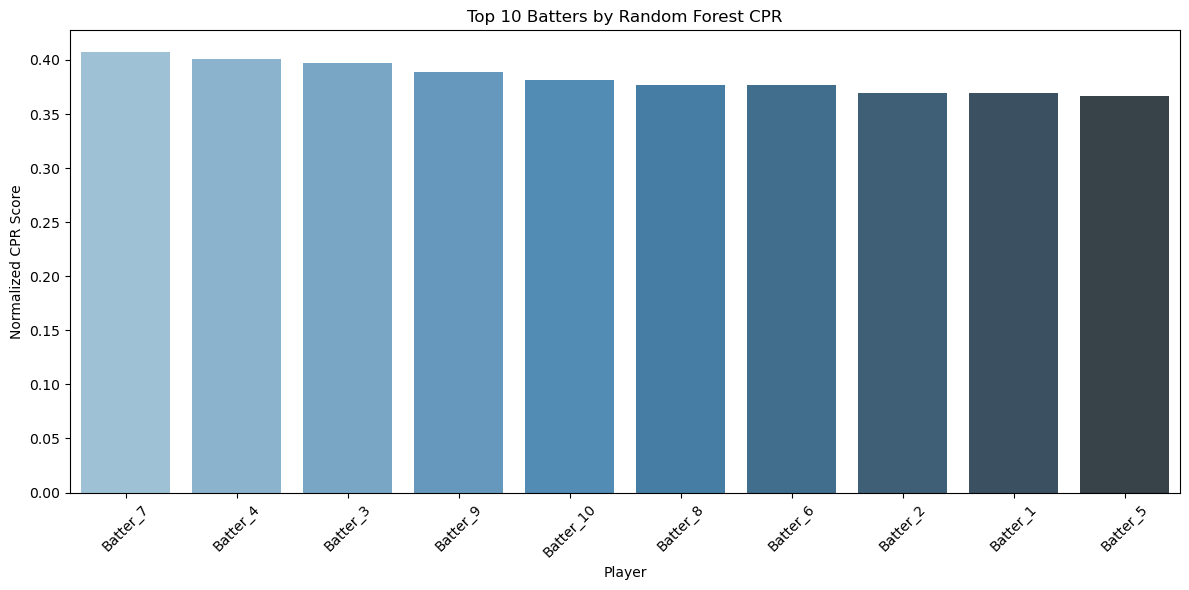

In [53]:
top10 = bat_ranked.sort_values(by='CPR_RF', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10,
    x='Player',
    y='CPR_RF',
    palette='Blues_d',
    order=top10['Player']  
)
plt.title('Top 10 Batters by Random Forest CPR')
plt.ylabel('Normalized CPR Score')
plt.xlabel('Player')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


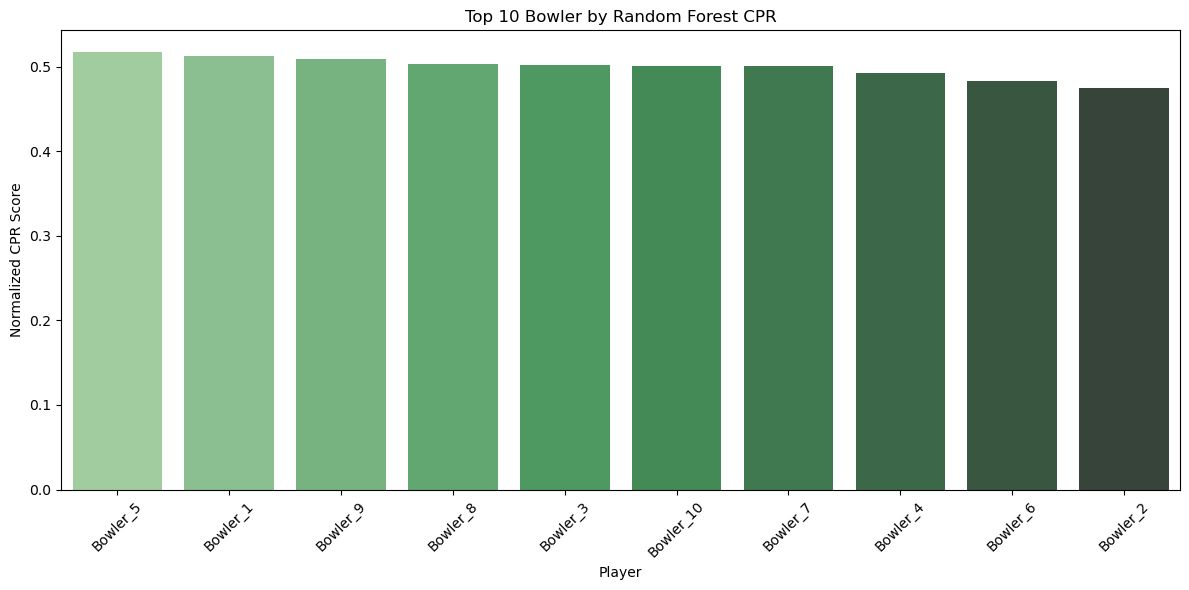

In [54]:
top10 = bowl_ranked.sort_values(by='CPR_RF', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10,
    x='Player',
    y='CPR_RF',
    palette='Greens_d',
    order=top10['Player']  
)
plt.title('Top 10 Bowler by Random Forest CPR')
plt.ylabel('Normalized CPR Score')
plt.xlabel('Player')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [55]:
# Model comparison plots
bat_df = pd.DataFrame(bat_results)
bowl_df = pd.DataFrame(bowl_results)

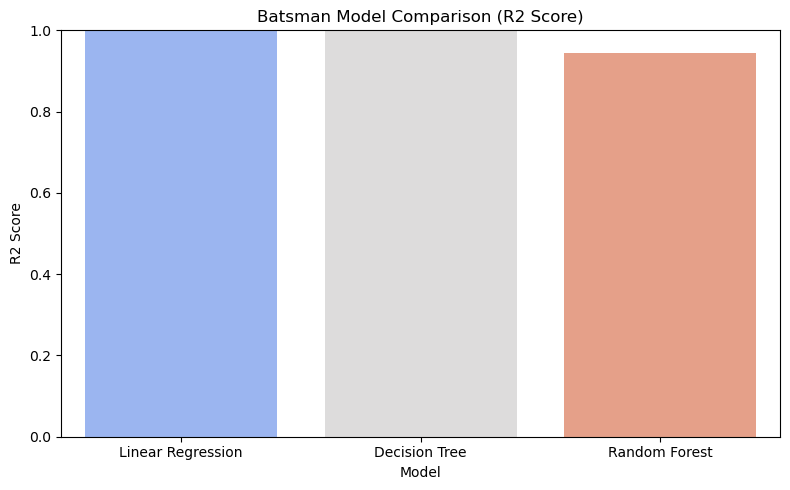

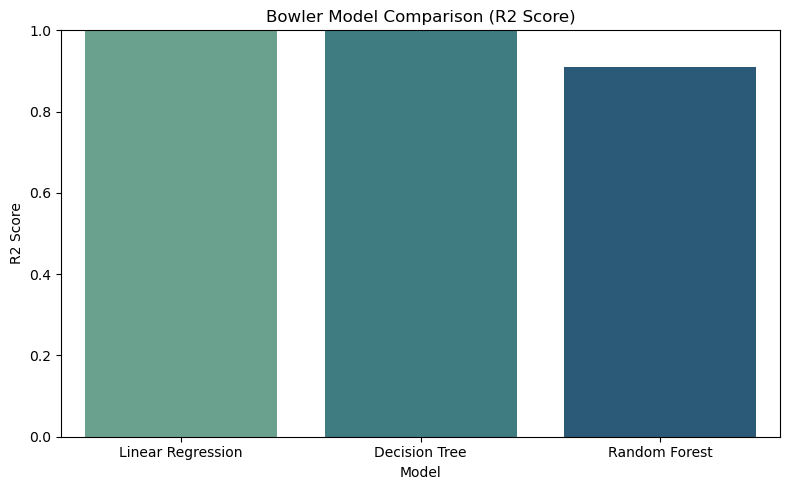

In [59]:
plt.figure(figsize=(8, 5))
sns.barplot(data=bat_df, x='Model', y='R2 Score', palette='coolwarm')
plt.title('Batsman Model Comparison (R2 Score)')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=bowl_df, x='Model', y='R2 Score', palette='crest')
plt.title('Bowler Model Comparison (R2 Score)')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()